### 1. Get data
Our dataset is a subset of the Food101 dataset.

Food101 starts 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our datasets starts with 3 classes of food and only 10% of the images(~75 training 25 testing).


In [5]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## 2. Data preparation and data exploration

In [6]:
 import os 
 def walk_through_dir(dir_path):
    """Walks through dir_path returning its contents."""
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [7]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\test'.
There are 0 directories and 25 images in 'data\pizza_steak_sushi\test\pizza'.
There are 0 directories and 19 images in 'data\pizza_steak_sushi\test\steak'.
There are 0 directories and 31 images in 'data\pizza_steak_sushi\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi\train'.
There are 0 directories and 78 images in 'data\pizza_steak_sushi\train\pizza'.
There are 0 directories and 75 images in 'data\pizza_steak_sushi\train\steak'.
There are 0 directories and 72 images in 'data\pizza_steak_sushi\train\sushi'.


In [8]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

## 2.1 Visualizing and image

1. Get all of the image paths
2. Pick a random image path using Pythons's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL
5. We'll then show the image and print metadata

Random image path: data\pizza_steak_sushi\train\pizza\2811032.jpg
Image class: pizza
Image height: 512
Image width: 512


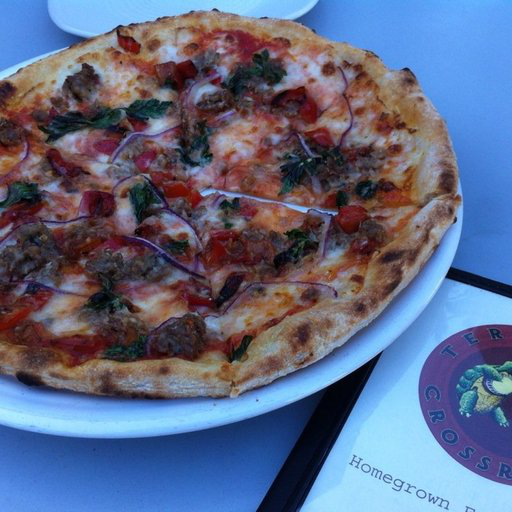

In [72]:
import random 
from PIL import Image
# Set seed
# random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem
# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")

img

##### We can do the same with matplotlib.pyplot.imshow(), expect we have to comvert the image to a NumPy array first

(-0.5, 511.5, 511.5, -0.5)

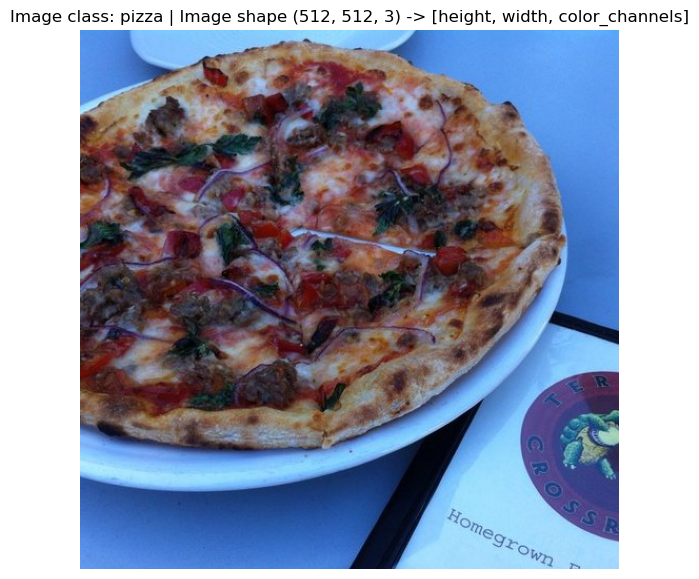

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asanyarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False)

In [77]:
img_as_array

array([[[ 80, 150, 236],
        [ 79, 149, 235],
        [ 79, 149, 235],
        ...,
        [ 82, 167, 247],
        [ 82, 169, 248],
        [ 84, 171, 250]],

       [[ 78, 148, 234],
        [ 78, 148, 234],
        [ 78, 148, 234],
        ...,
        [ 82, 167, 247],
        [ 84, 169, 249],
        [ 85, 170, 250]],

       [[ 77, 147, 233],
        [ 77, 147, 233],
        [ 77, 147, 233],
        ...,
        [ 85, 168, 248],
        [ 86, 169, 249],
        [ 87, 170, 250]],

       ...,

       [[ 97, 151, 241],
        [ 98, 152, 242],
        [100, 154, 244],
        ...,
        [163, 217, 255],
        [161, 215, 253],
        [159, 213, 251]],

       [[ 97, 151, 241],
        [ 99, 153, 243],
        [101, 155, 245],
        ...,
        [161, 215, 253],
        [160, 214, 252],
        [160, 214, 252]],

       [[ 96, 150, 240],
        [ 99, 153, 243],
        [101, 155, 245],
        ...,
        [158, 212, 250],
        [159, 213, 251],
        [161, 215, 253]]

## 3. Transforming data 

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`,we'll call these `Dataset` and `DataLoader`.

In [78]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [83]:
# Write a transform for image 
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size = (64,64)),
    # Flip the image randomly on the horizantal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [86]:
data_transform(img)

tensor([[[0.3569, 0.3647, 0.3765,  ..., 0.3098, 0.3137, 0.3176],
         [0.3647, 0.3725, 0.3765,  ..., 0.3176, 0.3255, 0.3333],
         [0.3647, 0.3686, 0.3765,  ..., 0.3216, 0.3294, 0.3412],
         ...,
         [0.6353, 0.6392, 0.6314,  ..., 0.3216, 0.3333, 0.3451],
         [0.6431, 0.6392, 0.6314,  ..., 0.3490, 0.3529, 0.3608],
         [0.6353, 0.6353, 0.6353,  ..., 0.3608, 0.3686, 0.3765]],

        [[0.6549, 0.6588, 0.6667,  ..., 0.5686, 0.5725, 0.5765],
         [0.6392, 0.6392, 0.6431,  ..., 0.5608, 0.5686, 0.5725],
         [0.6314, 0.6314, 0.6353,  ..., 0.5569, 0.5725, 0.5804],
         ...,
         [0.8471, 0.8510, 0.8549,  ..., 0.5412, 0.5529, 0.5608],
         [0.8549, 0.8549, 0.8510,  ..., 0.5647, 0.5686, 0.5765],
         [0.8471, 0.8471, 0.8471,  ..., 0.5765, 0.5843, 0.5882]],

        [[0.9765, 0.9843, 0.9882,  ..., 0.9176, 0.9176, 0.9216],
         [0.9725, 0.9765, 0.9765,  ..., 0.9098, 0.9176, 0.9216],
         [0.9647, 0.9686, 0.9725,  ..., 0.9059, 0.9176, 0.

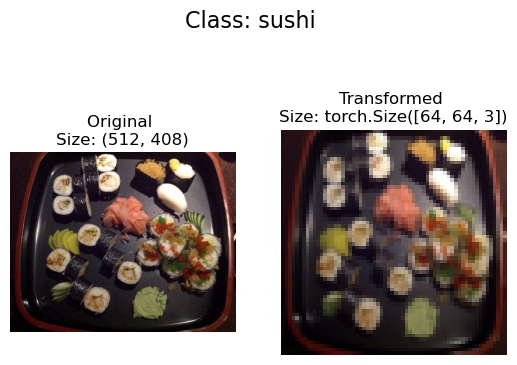

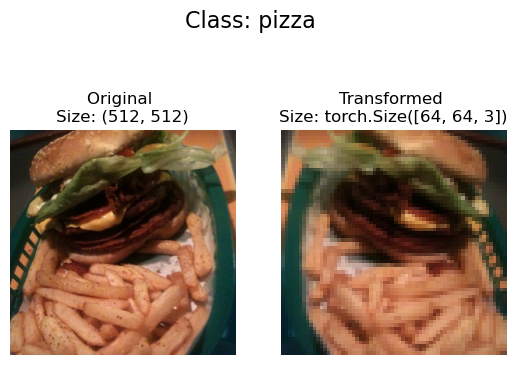

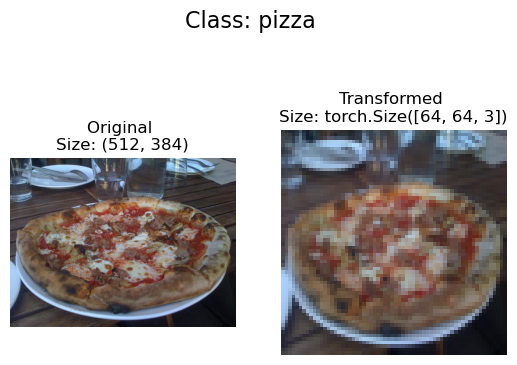

In [96]:
def plot_transformed_images(image_paths, transform, n = 3, seed = 42):
    """Plots a series of random images from image_paths.
        Will open n image paths from image_paths, transform them
        with transform and plot them side by side.

        Args: image_paths(list): List of target image_paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """

    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform= data_transform,
                        n = 3)

### 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`.

In [98]:
# Use ImageFolder to create dataset (s)
from torchvision import datasets
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = data_transform, # a transform for the data
                                  target_transform=None)  # a transform for the label/target
test_data = datasets.ImageFolder(root=test_dir,
                                 transform = data_transform)

train_data, test_data 

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [99]:
train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

In [100]:
# Get class name as list 
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [101]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [102]:
# Check the lengths of out dataset
len(train_data), len(test_data)

(225, 75)

In [103]:
train_data.targets

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [104]:
train_data.samples[0]

('data\\pizza_steak_sushi\\train\\pizza\\1008844.jpg', 0)

In [105]:
# Index on the train_data Dataset to get a single image and label
train_data[0]

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [108]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

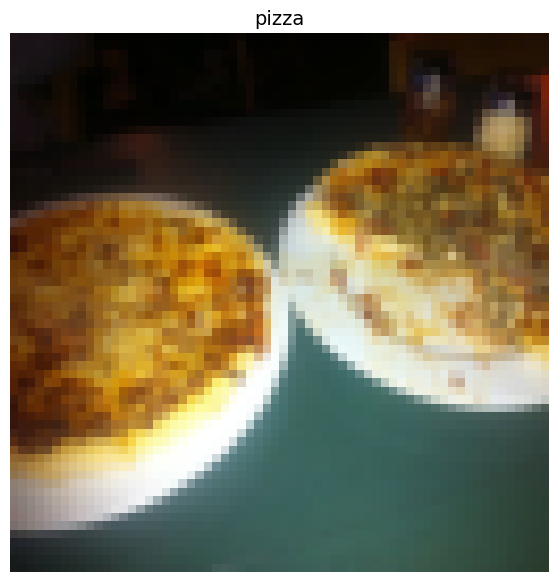

In [110]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize = 14)

## 4.1 Turn loaded images into `DataLoader's

A `DataLoader` is going to help us turn our `Dataset`s into iterables and we can customise the `batch_size` images at a time.

In [117]:
 # Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle = True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle = True)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1ef13754350>,
 <torch.utils.data.dataloader.DataLoader at 0x1ef13756870>)

In [118]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [120]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


# 5 Option 2: Loding Image Data with a Custom `Datasets`
1. Want to be able to load images from file 
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
    * Can create a `Dataset` out of almost anything
    * Not limited to `PyTorch` pre-built `Dataset` functions
    Cons:
    * Even though you could create `Dataset` out of almost anything, it doesn't mean it will work..
    * Using a custom `Dataset` often result in us writing more code, which could ve prone to errors or performance issues

In [121]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [122]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# 5.1 Creating a helper function to get class names 
We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory(ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [123]:
# Setup path for target directory 
target_directory = train_dir
print(f"Target dir: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [124]:
list(os.scandir(target_directory))

[<DirEntry 'pizza'>, <DirEntry 'steak'>, <DirEntry 'sushi'>]

In [133]:
# Make function to find classes in target directory
def find_classes(directory:str) -> Tuple[List[str], Dict[str, int]]:
    """ Finds the class folder names in target directory. 
    Assume target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        Find_classes("food_images/train")
        >>> (["xclass_1", "class_2", {"class_1": 0, ...}]) 
    """ 
    # 1. Get the class names by scannşng the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # 2. Raise am error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i , cls_name in enumerate(classes)}
    return classes, class_to_idx

In [134]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# 5.2 Create a custom `Dataset` to replicate  `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset` 
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - a list of the target classes
    * class_to_idx - a dict of the target classes mapped to intefer labels
4. Create a function to `load_images()`, this function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index

In [138]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize our custom dataset
    def __init__(self,
                 targ_dir: str,
                 transform = None):
        # 3. Create class attributes
        # Get all of the image paths 
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
        # Setup transform 
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)
    # 5. Overwrite __len()__
    def __len__(self) -> int:
        return len(self.paths)
    
     # 6. Overwrite __getitem()__ method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X,y)